This notebook generates maps of evaluation metrics to analyze the spatial distribution of model performance across basins. It can also produce ensemble maps by combining results from multiple runs trained with different random seeds.

In [ ]:
from pathlib import Path
import pandas as pd
from xarray.core.dataarray import DataArray
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

import json
import pickle
from collections import defaultdict
from pathlib import PosixPath
from typing import Callable, Dict, List, Tuple

import numpy as np
import tqdm
import xarray as xr
from scipy.stats import wilcoxon

In [24]:
# -------------- Paths --------------
RUNS_DIR=Path('./runs')
OUTPUT_TS_DIR = Path("./ensemble_timeseries")
OUTPUT_TS_DIR.mkdir(exist_ok=True)
METRICS_DIR = Path("./metrics")

In [6]:
ensemble = {}

In [6]:
RUN_PREFIX = "uy_gauge_precip_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1612_142943".lower()

In [7]:
nested_dir = OUTPUT_TS_DIR / f"{RUN_PREFIX}"
nested_dir.mkdir(parents=True, exist_ok=True)

In [8]:
def _mask_valid(obs, sim):
    # Create boolean mask of valid values
    mask = (~sim.isnull()) & (~obs.isnull())

    # Reduce mask to 1D if it has more than 1 dimension
    # (required by xarray for boolean indexing)
    if mask.ndim > 1:
        mask = mask.any(dim=[d for d in mask.dims if d != "date"])

    return obs[mask], sim[mask]

In [9]:
def _mask_valid(obs, sim):
    # Create boolean mask of valid values
    mask = (~sim.isnull()) & (~obs.isnull())

    # Reduce mask to 1D if it has more than 1 dimension
    if mask.ndim > 1:
        mask = mask.any(dim=[d for d in mask.dims if d != "date"])

    return obs[mask], sim[mask]


# ------- METRICS --------

def mse(obs, sim):
    o, s = _mask_valid(obs, sim)
    return float(np.mean((s - o) ** 2))


def rmse(obs, sim):
    return float(np.sqrt(mse(obs, sim)))


def nse(obs, sim):
    o, s = _mask_valid(obs, sim)
    denom = np.mean((o - o.mean()) ** 2)
    if denom == 0:
        return np.nan
    return float(1 - np.mean((s - o) ** 2) / denom)


def beta_kg(obs, sim):
    """Beta component of KGE: mean(sim) / mean(obs)."""
    o, s = _mask_valid(obs, sim)
    if np.mean(o) == 0:
        return np.nan
    return float(np.mean(s) / np.mean(o))

In [10]:
for run_dir in RUNS_DIR.iterdir():
    # Skip non-directories and hidden directories (.ipynb_checkpoints, .git, etc.)
    if not run_dir.is_dir() or run_dir.name.startswith("."):
        continue

    # Only process runs starting with "camelsus"
    if not run_dir.name.lower().startswith(RUN_PREFIX):  #("camelsus"):
        continue
    
    # Now run_dir is a directory inside RUNS_DIR
    print("Processing:", run_dir)

    results_dir = run_dir / "validation"
    
    # Find directories starting with model_epoch and sort
    dirs = [d for d in results_dir.iterdir() if d.is_dir() and d.name.startswith("model_epoch")]
    if not dirs:
        raise ValueError(f"No model_epoch directories found in {results_dir}")
    
    sorted_dirs = sorted(dirs, key=lambda d: int(d.name.replace("model_epoch", "")))
    largest = sorted_dirs[-1]
    print(f"Using directory: {largest}")

    # Paths to validation results
    pickle_file = largest / "validation_results.p"
    metrics_file = largest / "validation_metrics.csv"

    # Load validation results
    with open(pickle_file, "rb") as f:
        results = pickle.load(f)
    
    for basin_id, by_freq in results.items():
        
        xr_block = by_freq["1D"]["xr"]

        # Automatically pick obs / sim variables
        data_vars = list(xr_block.data_vars)
        obs_var = next(k for k in data_vars if k.endswith("_obs"))
        sim_var = next(k for k in data_vars if k.endswith("_sim"))

        qobs = xr_block[obs_var]
        qsim = xr_block[sim_var]

        qobs, qsim = _mask_valid(qobs, qsim)
        
        # Initialize ensemble entry
        if basin_id not in ensemble:
            ensemble[basin_id] = {
                "qsim_sum": np.zeros_like(qsim, dtype=float),
                "count": 0,
                "qobs": qobs,
            }

        # Add this run's simulation
        ensemble[basin_id]["qsim_sum"] += qsim
        ensemble[basin_id]["count"] += 1

Processing: runs/uy_gauge_precip_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1612_142943
Using directory: runs/uy_gauge_precip_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1612_142943/validation/model_epoch030


In [11]:
ensemble_metrics = {}

for basin_id, data in ensemble.items():

    # mean of ensemble
    mean_sim = data["qsim_sum"] / data["count"]
    mean_sim = np.squeeze(mean_sim)    # <<–– FIX HERE

    obs = data["qobs"]
    obs = obs.squeeze()                # just to be safe

    # ---- Save ensemble time series ----
    sim_da = xr.DataArray(
        mean_sim,
        coords={"date": obs.date},
        dims=["date"],
        name="qsim_ensemble"
    )

    ds = xr.Dataset({
        "qobs": obs,
        "qsim_ensemble": sim_da
    })

    out_path = nested_dir / f"{basin_id}.nc"
    ds.to_netcdf(out_path)

    # ---- Metrics ----
    ensemble_metrics[basin_id] = {
        "ensemble_nse": nse(obs, mean_sim),
        "ensemble_mse": mse(obs, mean_sim),
        "ensemble_rmse": rmse(obs, mean_sim),
        "ensemble_beta_kg": beta_kg(obs, mean_sim),
        "num_models": data["count"]
    }

In [12]:
# ---------------- Save metrics CSV ----------------

df_ensemble = pd.DataFrame.from_dict(ensemble_metrics, orient="index")
df_ensemble.index.name = "basin_id"
df_ensemble.reset_index(inplace=True)

output_file = METRICS_DIR / f"{RUN_PREFIX}_ensemble_metrics.csv"
df_ensemble.to_csv(output_file, index=False)

print(f"\nEnsemble metrics saved to {output_file}")
print(f"Ensemble time series saved to {OUTPUT_TS_DIR.resolve()}")


Ensemble metrics saved to metrics/uy_gauge_precip_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1612_142943_ensemble_metrics.csv
Ensemble time series saved to /mmfs1/gscratch/stf/hernanqd/project/pruebas/replicating_results/ensemble_timeseries


# Metrics (CAMELS)

In [7]:
RUN_PREFIX = "uy_and_camels".lower()

In [8]:
ATTRIBUTES_FILE = Path("../../../neuralhydrology/data/CAMELS_US/camels_attributes_v2.0/camels_topo.txt")

In [13]:
def plot_nse_map_camels(NSE_THRESHOLD=None):
    """
    Plot NSE values from the latest model_epoch directory with basemap.
    
    Parameters:
    -----------
    run_dir_name : str or Path
        Name of the run directory inside './runs'.
    period : str or Path
        Subdirectory under the run directory (e.g., 'validation').
    """
    
    # Load metrics
    metrics = pd.read_csv(Path("metrics") / f"{RUN_PREFIX}_ensemble_metrics.csv")
    metrics = metrics.rename(columns={"basin_id": "gauge_id"}).set_index("gauge_id")
    
    # Load attributes
    attributes = pd.read_csv(ATTRIBUTES_FILE, delimiter=";")
    attributes["gauge_id"] = attributes["gauge_id"].astype(str).str.zfill(8)
    attributes = attributes.set_index("gauge_id")
    # attributes = pd.read_csv(ATTRIBUTES_FILE, delimiter = ";").set_index("gauge_id")
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        attributes,
        geometry=gpd.points_from_xy(attributes["gauge_lon"], attributes["gauge_lat"]),
        crs="EPSG:4326"
    )

    # Merge NSE
    merged = gdf.merge(metrics[["ensemble_rmse"]], left_index=True, right_index=True, how="left")
    
    # Apply threshold only if provided
    if NSE_THRESHOLD is not None:
        merged = merged[merged["ensemble_rmse"] >= NSE_THRESHOLD]
        
    # Convert to Web Mercator for basemap
    merged_web = merged.to_crs(epsg=3857)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    plot = merged_web.plot(
        column="ensemble_rmse",
        cmap="viridis",
        legend=True,
        markersize=60,
        ax=ax,
        vmin=0,
        vmax=6
    )
    
    # Add colorbar label
    cbar = plot.get_figure().get_axes()[1]
    cbar.set_ylabel("ensemble_rmse", rotation=270, labelpad=15)
    
    # Add basemap
    cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
    
    ax.set_title("RMSE by Gauge Location")
    plt.show()

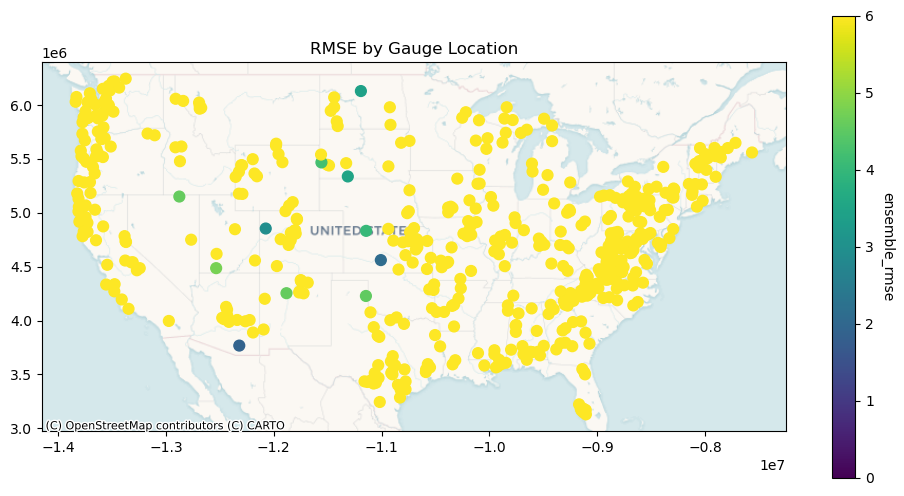

In [14]:
plot_nse_map_camels()

# NSE (CARAVAN)

In [13]:
RUN_PREFIX = "uy_gauge_precip_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1612_142943".lower()

In [14]:
ATTRIBUTES_FILE = Path("../../data/attributes/attributes_other.csv")

In [15]:
def plot_nse_map(NSE_THRESHOLD=None):
    """
    Plot NSE values from the latest model_epoch directory with basemap.
    
    Parameters:
    -----------
    run_dir_name : str or Path
        Name of the run directory inside './runs'.
    period : str or Path
        Subdirectory under the run directory (e.g., 'validation').
    """
    
    # Load metrics
    metrics = pd.read_csv(Path("metrics") / f"{RUN_PREFIX}_ensemble_metrics.csv")
    metrics = metrics.rename(columns={"basin_id": "gauge_id"}).set_index("gauge_id")

    # # Keep only CAMELS_UY basins
    # metrics = metrics[metrics.index.str.startswith("CAMELS_UY")]
    
    # Load attributes
    attributes = pd.read_csv(ATTRIBUTES_FILE).set_index("gauge_id")
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        attributes,
        geometry=gpd.points_from_xy(attributes["gauge_lon"], attributes["gauge_lat"]),
        crs="EPSG:4326"
    )
    
    # Merge NSE
    merged = gdf.merge(metrics[["ensemble_nse"]], left_index=True, right_index=True, how="left")

    # Apply threshold only if provided
    if NSE_THRESHOLD is not None:
        merged = merged[merged["ensemble_nse"] >= NSE_THRESHOLD]
        
    # Convert to Web Mercator for basemap
    merged_web = merged.to_crs(epsg=3857)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    plot = merged_web.plot(
        column="ensemble_nse",
        cmap="viridis",
        legend=True,
        markersize=60,
        ax=ax,
        vmin=0,
        vmax=0.5
    )
    
    # Add colorbar label
    cbar = plot.get_figure().get_axes()[1]
    cbar.set_ylabel("ensemble_nse", rotation=270, labelpad=15)
    
    # Add basemap
    cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
    
    ax.set_title("NSE by Gauge Location")
    plt.show()

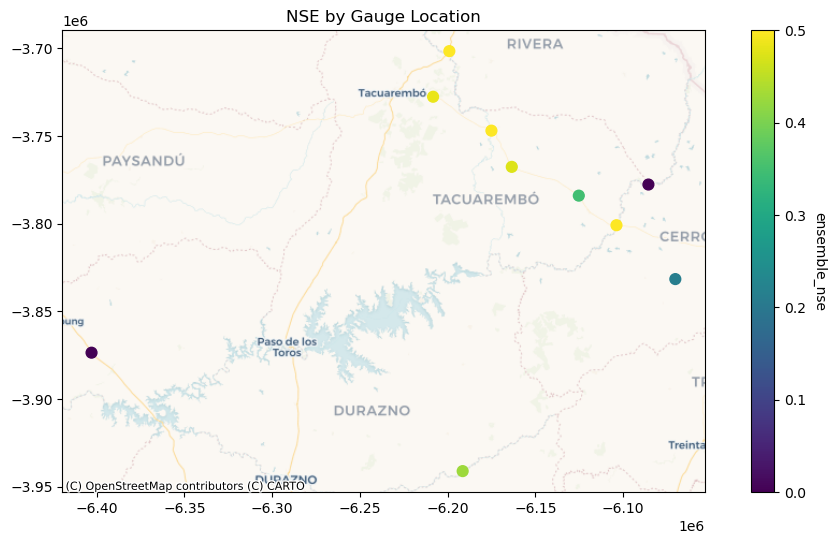

In [16]:
plot_nse_map()

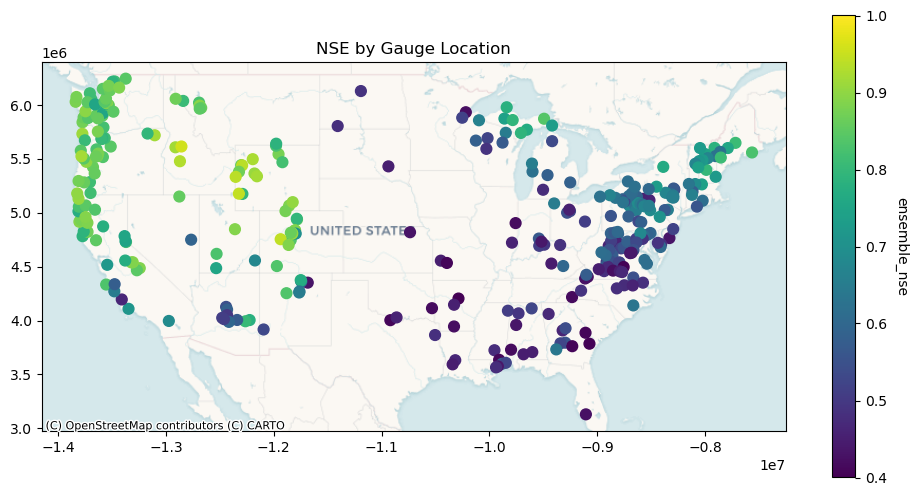

In [44]:
plot_nse_map(0.4)

# NSE difference

In [46]:
RUN_PREFIX = "caravan".lower()

In [63]:
def plot_nse_difference_map(NSE_THRESHOLD=None):
    """
    Plot the difference between current NSE and CAMELSUS NSE with basemap.
    Difference = ensemble_nse_current - ensemble_nse_camelsus
    """

    # Load metrics for the current RUN_PREFIX
    metrics = pd.read_csv(Path("metrics") / f"{RUN_PREFIX}_ensemble_metrics.csv")
    metrics = metrics.rename(columns={"basin_id": "gauge_id"}).set_index("gauge_id")

    # ---- Load CAMELSUS metrics ----
    camelsus = pd.read_csv(Path("metrics") / "camelsus_ensemble_metrics.csv")

    # Fix basin_id: ensure 8-digit code, then add "camels_" prefix
    camelsus["basin_id"] = (
        camelsus["basin_id"]
        .astype(str)
        .str.zfill(8)
        .apply(lambda x: f"camels_{x}")
    )
    camelsus = camelsus.set_index("basin_id")

    # Load attributes
    attributes = pd.read_csv(ATTRIBUTES_FILE).set_index("gauge_id")

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        attributes,
        geometry=gpd.points_from_xy(attributes["gauge_lon"], attributes["gauge_lat"]),
        crs="EPSG:4326"
    )

    # ---- Merge NSE from both sources ----
    merged = (
        gdf.merge(
            metrics[["ensemble_nse"]],
            left_index=True, right_index=True,
            how="left"
        )
        .merge(
            camelsus[["ensemble_nse"]],
            left_index=True, right_index=True,
            how="left",
            suffixes=("_current", "_camelsus")
        )
    )

    # Compute difference
    merged["nse_difference"] = merged["ensemble_nse_current"] - merged["ensemble_nse_camelsus"]

    # Apply threshold if provided
    if NSE_THRESHOLD is not None:
        excluded = merged[merged["nse_difference"].abs() > NSE_THRESHOLD]
        merged = merged[merged["nse_difference"].abs() <= NSE_THRESHOLD]

        # Save the list of basins to a text file
        basins_list = merged.index.tolist()
        # Output filename 
        with open("basins_list.txt", "w") as f:
            for basin in basins_list:
                f.write(f"{basin}\n")

        # Save excluded basins
        with open("basins_excluded.txt", "w") as f:
            for basin in excluded.index.tolist():
                f.write(f"{basin}\n")
    
        print(f"Saved {len(excluded)} excluded basins")
        
        print(f"Saved {len(basins_list)} basins")
        
    
    # Convert to Web Mercator
    merged_web = merged.to_crs(epsg=3857)

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(12, 6))
    plot = merged_web.plot(
        column="nse_difference",
        cmap="bwr",  # blue-white-red for differences
        legend=True,
        markersize=60,
        ax=ax,
        vmin=-0.6,  # adjust range as needed
        vmax=0.2,
        edgecolor="black",  # adds a black border to each dot
        linewidth=0.4       # optional: thickness of the border
    )

    # Fix colorbar label
    cbar = plot.get_figure().get_axes()[1]
    cbar.set_ylabel("NSE Difference (CARAVAN - CAMELSUS)", rotation=270, labelpad=15)

    # Basemap
    cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

    ax.set_title("Difference in NSE by Gauge Location")
    plt.show()

Saved 241 excluded basins
Saved 290 basins


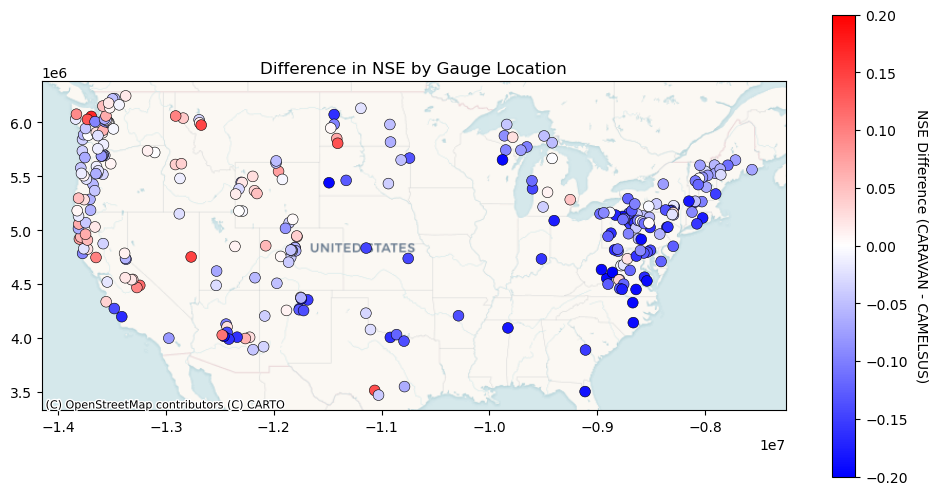

In [57]:
plot_nse_difference_map(0.2)

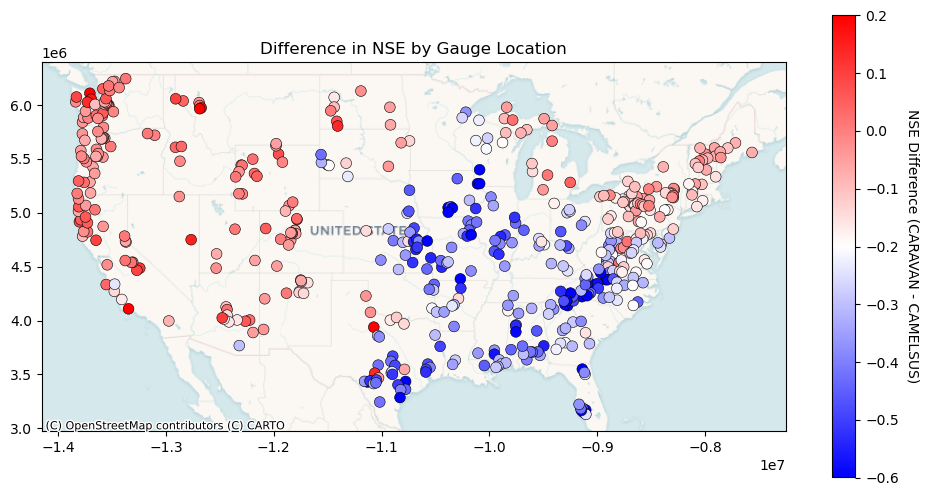

In [64]:
plot_nse_difference_map()

# Hydrographs from .nc (for ensembles)

In [21]:
def plot_validation_results_from_nc(nc_dir, metrics_csv):
    """
    Load validation results from a directory containing NetCDF files
    and plot obs vs sim for each basin.

    Parameters
    ----------
    nc_dir : str or Path
        Directory containing .nc files for each basin.
    metrics_csv : str or Path
        CSV file with columns ['basin', 'NSE'].
    """

    nc_dir = Path(nc_dir)

    # ---- Load NSE CSV ----
    metrics_df = pd.read_csv(metrics_csv)
    nse_lookup = dict(zip(metrics_df['basin_id'], metrics_df['ensemble_nse']))

    # ---- Output directory ----
    run_name = nc_dir.name
    out_dir = PLOTS_DIR / run_name
    out_dir.mkdir(parents=True, exist_ok=True)

    # ---- List all nc files ----
    nc_files = sorted(nc_dir.glob("*.nc"))
    if not nc_files:
        raise FileNotFoundError(f"No .nc files found in {nc_dir}")

    # ---- Loop over files ----
    for nc_file in nc_files:

        # Basin name = filename without extension
        basin_id = nc_file.stem

        # Skip non CAMELS_UY basins if needed
        if not basin_id.startswith("CAMELS_UY"):
            continue

        # Load dataset
        ds = xr.open_dataset(nc_file)

        # ---- Identify obs and sim variables ----
        data_vars = list(ds.data_vars)

        obs_var = next((v for v in data_vars if v.endswith("obs")), None)
        sim_var = next((v for v in data_vars if v.endswith("ensemble")), None)

        if obs_var is None or sim_var is None:
            print(f"⚠️ {basin_id} missing obs/sim variables. Skipping.")
            continue

        qobs = ds[obs_var]
        qsim = ds[sim_var]

        # ---- Identify time dimension ----
        time_coord = next((c for c in ["time", "date", "time_step"] if c in ds.coords), None)
        if time_coord is None:
            time = range(qobs.shape[0])
        else:
            time = ds[time_coord].values

        # ---- NSE from CSV ----
        nse_val = nse_lookup.get(basin_id, float('nan'))

        # ---- Plot ----
        plt.figure(figsize=(12, 4))
        plt.plot(time, qobs, label="Observed")
        plt.plot(time, qsim, label="Simulated")

        plt.title(f"Validation — Basin {basin_id} — NSE: {nse_val:.3f}")
        plt.xlabel("Date")
        plt.ylabel("Streamflow (mm/d)")
        plt.legend()
        plt.grid(alpha=0.3)

        # ---- Save ----
        out_path = out_dir / f"{basin_id}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

    print(f"Validation plots saved to: {out_dir.resolve()}")


In [22]:
nc_dir = "./ensemble_timeseries/uy_gauge_precip_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1612_142943"
metrics_csv = "./metrics/uy_gauge_precip_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1612_142943_ensemble_metrics.csv"
plot_validation_results_from_nc(nc_dir, metrics_csv)

Validation plots saved to: /mmfs1/gscratch/stf/hernanqd/project/pruebas/replicating_results/evaluation_plots/uy_gauge_precip_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1612_142943
